<a href="https://colab.research.google.com/github/erick9328/streamlit_app_tipo_de_zona/blob/main/Verificador_de_Clientes_en_Zonas_Peligrosas_(GeoPandas_%2B_KoBoToolbox).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Verificador de Clientes en Zonas Peligrosas (GeoPandas + KoBoToolbox)
Este notebook permite:
- Leer clientes desde un archivo GeoJSON
- Consultar zonas peligrosas desde KoBoToolbox
- Verificar si un cliente está dentro de una zona de riesgo
- Mostrar resultados y visualización en un mapa

In [2]:
# Importamos Librerias

import geopandas as gpd
import pandas as pd
import requests
from shapely.geometry import Point
import matplotlib.pyplot as plt

## Cargar archivo de clientes

💡 Sobre el formato GeoJSON

El formato .geojson es una estructura basada en JSON que permite almacenar datos geográficos. Contiene geometrías como Puntos, Líneas y Polígonos, junto con atributos descriptivos. Es ideal para compartir datos espaciales en la web y es soportado por la mayoría de los SIG.


*   Este archivo contiene 1000 puntos de clientes ubicados en Guayaquil que se crearon con IA de forma aleatoria.
*   Cada punto representa un cliente con un ID, coordenadas.





In [5]:
# Asegúrate de subir el archivo a la izquierda
clientes = gpd.read_file("clientes_1000_guayaquil.geojson")
clientes.head()

,id_cliente,nombre,lat,lon,geometry
0,1,Cliente_1,-2.225092,-80.003717,POINT (-80.00372 -2.22509)
1,2,Cliente_2,-2.109857,-79.914525,POINT (-79.91452 -2.10986)
2,3,Cliente_3,-2.153601,-79.831764,POINT (-79.83176 -2.1536)
3,4,Cliente_4,-2.180268,-79.866944,POINT (-79.86694 -2.18027)
4,5,Cliente_5,-2.268796,-79.848360,POINT (-79.84836 -2.2688)


## Conectarse a KoBoToolbox y obtener zonas

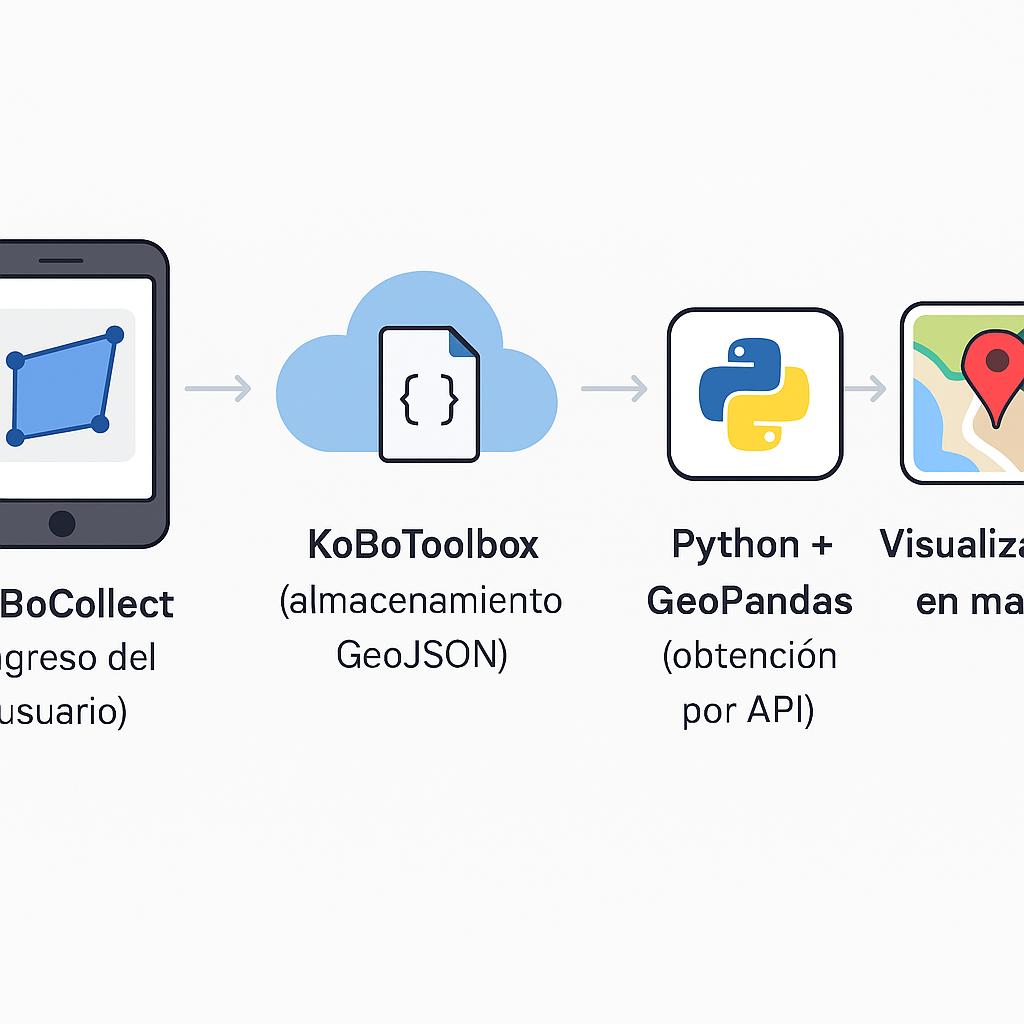

In [6]:
import json
import tempfile
import geopandas as gpd
import requests

# -------------------------------------------------------------------------
# 📡 DESCARGA AUTOMÁTICA DE ZONAS PELIGROSAS DESDE KoBoToolbox
# Este bloque se conecta a KoBoToolbox usando una API privada (Token)
# para obtener la capa de zonas peligrosas que han sido reportadas
# desde el formulario de campo por asesores o usuarios.
# -------------------------------------------------------------------------

# Token de autenticación privada (no compartir públicamente)
KOBO_TOKEN = "0774fbe5459f53c43df932e9cbbf4bc7933d09cb"

# ID del formulario de KoBoToolbox (cada formulario tiene un ID único)
FORM_ID = "aqY6oRXU7iELs6bmj3VuwB"

# Construcción del endpoint y headers
headers = {"Authorization": f"Token {KOBO_TOKEN}"}
url = f"https://kf.kobotoolbox.org/api/v2/assets/{FORM_ID}/data.geojson"

# Se realiza la petición al API
response = requests.get(url, headers=headers)

# Si la respuesta es exitosa (200 OK):
if response.status_code == 200:
    # Guardamos temporalmente el contenido del GeoJSON en disco
    with tempfile.NamedTemporaryFile(mode="w+", suffix=".geojson", delete=False) as tmp:
        tmp.write(response.text)
        tmp_path = tmp.name

    # Leemos el archivo GeoJSON con GeoPandas
    zonas = gpd.read_file(tmp_path)

    # Aseguramos que el sistema de coordenadas sea WGS84 (EPSG:4326)
    if zonas.crs is None:
        zonas = zonas.set_crs(epsg=4326)

else:
    zonas = None
    print("❌ Error al descargar las zonas desde KoBoToolbox.")


## Validar si el cliente está en zona peligrosa

In [7]:
cliente_id = 6  # Cambia este número para probar con otros clientes, probar con el códifo 6 o 109
cliente = clientes[clientes['id_cliente'] == cliente_id].iloc[0]  # Busca el cliente por ID y extrae la fila (registro) correspondiente
punto = cliente.geometry #Obtiene las coordenadas del cliente seleccionado
riesgo = any(z.contains(punto) for z in zonas.geometry) # Evalúa si ese punto cae dentro de alguna zona peligrosa con un cruce espacial
# Imprimimos el resultado de la validación
if riesgo:
    print("🛑 Cliente en zona peligrosa")
else:
    print("✅ Cliente en zona segura")

🛑 Cliente en zona peligrosa


## Mapa de clientes y zonas peligrosas

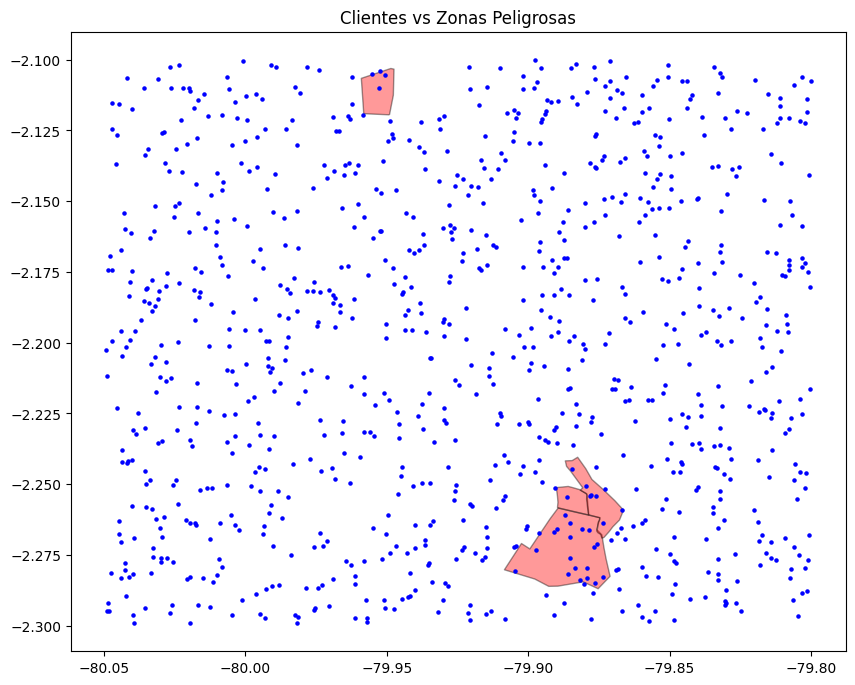

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
zonas.plot(ax=ax, color='red', alpha=0.4, edgecolor='black')
clientes.plot(ax=ax, color='blue', markersize=5)
ax.set_title("Clientes vs Zonas Peligrosas")
plt.show()

In [9]:
import folium
import json

# VISUALIZACIÓN DE ZONAS PELIGROSAS Y CLIENTES EN UN MAPA INTERACTIVO

#Clonamos el GeoDataFrame de zonas para no alterar el original
zonas_clean = zonas.copy()

# Convertimos a string todos los valores que pueden causar problemas al serializar a JSON,
# por ejemplo: fechas, listas o diccionarios dentro de los atributos.
zonas_clean = zonas_clean.applymap(
    lambda val: str(val) if isinstance(val, (pd.Timestamp, dict, list)) else val
)

# Convertimos el GeoDataFrame limpio a un diccionario GeoJSON seguro para folium
zonas_geojson = json.loads(zonas_clean.to_json())

# Creamos el mapa base centrado en Guayaquil
m = folium.Map(location=[-2.18, -79.9], zoom_start=12)

# Añadimos las zonas peligrosas como polígonos rojos al mapa,
#    con tooltip informativo para cada polígono.
folium.GeoJson(
    zonas_geojson,
    name="Zonas peligrosas",
    style_function=lambda x: {
        "fillColor": "red",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.4,
    },
    tooltip=folium.GeoJsonTooltip(fields=[
        "grupo_zona/nombre_zona",
        "grupo_zona/tipo_riesgo",
        "grupo_zona/observaciones"
    ])
).add_to(m)

# Añadimos los clientes como puntos azules sobre el mapa
for _, row in clientes.iterrows():
    coords = row.geometry.y, row.geometry.x  # lat, lon
    folium.CircleMarker(
        location=coords,
        radius=3,
        color='blue',
        fill=True,
        fill_opacity=0.7,
        popup=f"ID Cliente: {row['id_cliente']}"
    ).add_to(m)

# Mostramos el mapa interactivo (solo se visualiza en notebooks compatibles como Colab o JupyterLab)
m


/tmp/ipython-input-9-2653656963.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  zonas_clean = zonas_clean.applymap(


In [20]:
# Crear GeoDataFrame con clientes en zonas peligrosas
clientes_en_zona = gpd.sjoin(clientes, zonas, how="inner", predicate="within")

# Mostrar tabla con columnas relevantes
clientes_en_zona[["id_cliente", "grupo_zona/nombre_zona", "grupo_zona/tipo_riesgo", "grupo_zona/observaciones"]].head()


/tmp/ipython-input-20-84337054.py:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4979

  clientes_en_zona = gpd.sjoin(clientes, zonas, how="inner", predicate="within")


,id_cliente,grupo_zona/nombre_zona,grupo_zona/tipo_riesgo,grupo_zona/observaciones
5,6,Guasmo Sur,alta,Zona de alta peligrosidad
14,15,Vergeles,alta,Alta peligrosidad
108,109,Vergeles,alta,Alta peligrosidad
124,125,Floresta,alta,None
152,153,Guasmo Sur,alta,Zona de alta peligrosidad
